# Metocean use case - extract data from dfsu and netcdf files

2D model results stored in NetCDF or Grib can be loaded to ModelSkill using xarray. In this way, MIKE 21 modelresults in dfsu format can easily be compared to model results from third party providers often stored in NetCDF. 

In [1]:
import xarray as xr
import modelskill as ms

## Observations

2 point observations and 1 track observation from Satellite altimetry. 

In [2]:
o1 = ms.PointObservation('examples/metocean/HKNA_Hm0.dfs0', item=0, x=4.0, y=52.8, name="HKNA")
o2 = ms.PointObservation("examples/metocean/eur_Hm0.dfs0", item=0, x=3.2760, y=51.9990, name="EPL")
o3 = ms.TrackObservation("examples/metocean/Alti_c2_Dutch.dfs0", item=3, name="c2")

## MIKE ModelResult

In [3]:
mrMIKE = ms.model_result('examples/metocean/HKZN_local_2017_DutchCoast.dfsu', name='MIKE21SW', item=0)
mrMIKE2 = ms.model_result('examples/metocean/DutchCoast_2017_subset_v2.dfsu', name='MIKE21SW_v2', item=0)

## Spatial overview

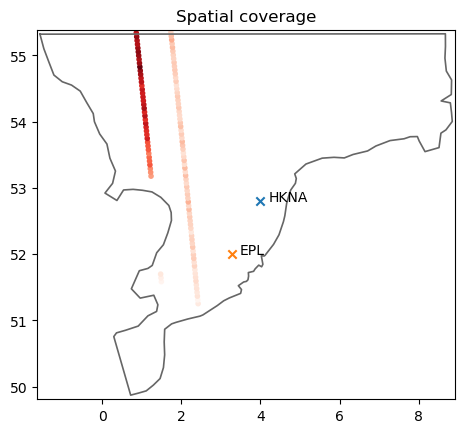

In [4]:
ms.plotting.spatial_overview(obs=[o1,o2,o3], mod=mrMIKE);

In [5]:
cc = ms.match(obs=[o1,o2,o3], mod=[mrMIKE, mrMIKE2])
cc.skill()

n      bias      rmse     urmse       mae  \
model       observation                                                
MIKE21SW    HKNA         386 -0.111389  0.296050  0.274295  0.207626   
            EPL           67 -0.077520  0.227927  0.214339  0.192689   
            c2            70 -0.126145  0.384043  0.362735  0.336453   
MIKE21SW_v2 HKNA         386 -0.214659  0.358371  0.286970  0.257492   
            EPL           67 -0.164039  0.267525  0.211331  0.232836   
            c2            70 -0.203239  0.393326  0.336748  0.345799   

                               cc        si        r2  
model       observation                                
MIKE21SW    HKNA         0.973476  0.088306  0.932999  
            EPL          0.969454  0.082866  0.929960  
            c2           0.950580  0.154210  0.738691  
MIKE21SW_v2 HKNA         0.973476  0.092387  0.901821  
            EPL          0.969454  0.081703  0.903509  
            c2           0.950564  0.143162  0.725907

## NetCDF ModelResult

In [6]:
fn = "examples/metocean/ERA5_DutchCoast.nc"
xr.open_dataset(fn)

<xarray.Dataset>
Dimensions:    (longitude: 20, latitude: 11, time: 67)
Coordinates:
  * longitude  (longitude) float32 -1.0 -0.5 0.0 0.5 1.0 ... 6.5 7.0 7.5 8.0 8.5
  * latitude   (latitude) float32 55.0 54.5 54.0 53.5 ... 51.5 51.0 50.5 50.0
  * time       (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    mwd        (time, latitude, longitude) float32 ...
    mwp        (time, latitude, longitude) float32 ...
    mp2        (time, latitude, longitude) float32 ...
    pp1d       (time, latitude, longitude) float32 ...
    swh        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [7]:
mrERA5 = ms.model_result(fn, item="swh", name='ERA5')
mrERA5

<GridModelResult>: ERA5
Time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00
Quantity: Significant height of combined wind waves and swell [m]

In [8]:
mrERA5.data  # mr contains the xr.Dataset

<xarray.Dataset>
Dimensions:  (time: 67, y: 11, x: 20)
Coordinates:
  * x        (x) float32 -1.0 -0.5 0.0 0.5 1.0 1.5 ... 6.0 6.5 7.0 7.5 8.0 8.5
  * y        (y) float32 55.0 54.5 54.0 53.5 53.0 52.5 52.0 51.5 51.0 50.5 50.0
  * time     (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    swh      (time, y, x) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

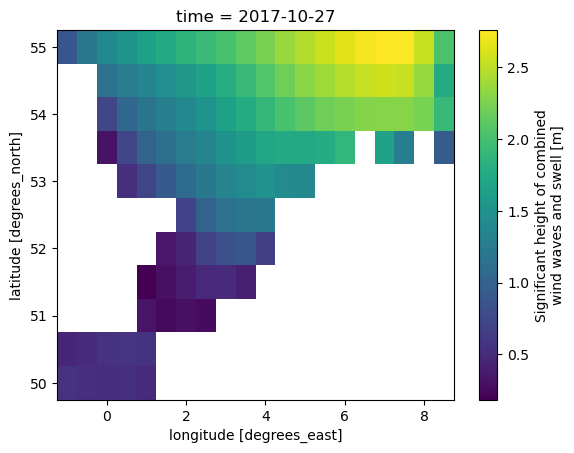

In [9]:
mrERA5.data.swh.isel(time=0).plot()

## Test extract from XArray

1) Extract point 
2) Extract track

In [10]:
mrERA5.extract(o1)

<PointModelResult>: ERA5
Location: 4.0, 52.8
Time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00
Quantity: Significant height of combined wind waves and swell [m]

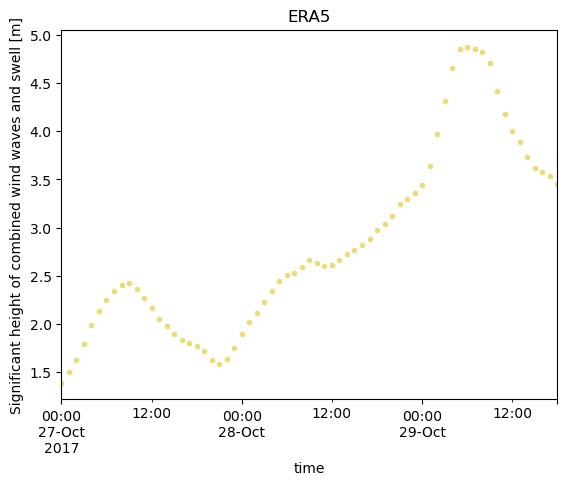

In [11]:
mrERA5.extract(o1).plot()

In [12]:
mrERA5.extract(o3).to_dataframe().head()

,x,y,ERA5
time,,,
2017-10-27 12:52:52.337,2.422854,51.253353,1.438809
2017-10-27 12:52:53.280,2.413789,51.310268,1.464191
2017-10-27 12:52:54.224,2.404711,51.367184,1.489200
2017-10-27 12:52:55.167,2.395619,51.424099,1.513833
2017-10-27 12:52:56.111,2.386516,51.481014,1.538092


## Multi-file ModelResult

Use mfdataset to load multiple files as a single ModelResult. Here from CMEMS Meteo-France.

In [13]:
fn = "examples/metocean/CMEMS_DutchCoast_*.nc"   # Note the wildcard!
mrCMEMS = ms.model_result(fn, item="VHM0", name='CMEMS')
mrCMEMS

<GridModelResult>: CMEMS
Time: 2017-10-28 00:00:00 - 2017-10-29 18:00:00
Quantity: Spectral significant wave height (Hm0) [m]

In [14]:
mrCMEMS.data

<xarray.Dataset>
Dimensions:  (time: 15, y: 27, x: 51)
Coordinates:
  * time     (time) datetime64[ns] 2017-10-28 ... 2017-10-29T18:00:00
  * x        (x) float32 -1.4 -1.2 -1.0 -0.8 -0.6 -0.4 ... 7.8 8.0 8.2 8.4 8.6
  * y        (y) float32 50.0 50.2 50.4 50.6 50.8 ... 54.4 54.6 54.8 55.0 55.2
Data variables:
    VHM0     (time, y, x) float32 dask.array<chunksize=(8, 27, 51), meta=np.ndarray>
Attributes: (12/30)
    CDI:                           Climate Data Interface version 1.9.3 (http...
    Conventions:                   CF-1.6
    CDO:                           Climate Data Operators version 1.9.3 (http...
    time_coverage_start:           20171028-00:00:00
    time_coverage_end:             20171028-21:00:00
    date_created:                  20200406-10:30:00
    ...                            ...
    geospatial_lat_step:           0.2
    geospatial_lat_units:          degree
    version:                       1.1
    product_type:                  Multi Year Product
    institution:                   Meteo France and Mercator Ocean
    title:                         Mean fields from global wave model MFWAM o...

## Match multiple models and observations and extract

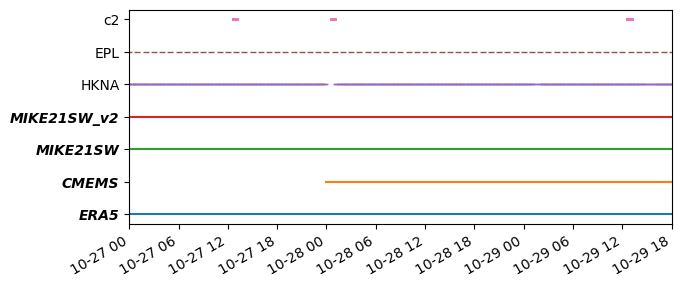

In [15]:
ms.plotting.temporal_coverage(obs=[o1,o2,o3], mod=[mrERA5, mrCMEMS, mrMIKE, mrMIKE2]);

In [16]:
cc = ms.match(obs=[o1,o2,o3], mod=[mrERA5, mrCMEMS, mrMIKE, mrMIKE2])
cc

<ComparerCollection>
Comparers:
0: HKNA - Significant wave height [m]
1: EPL - Significant wave height [m]
2: c2 - Significant wave height [m]

## Analysis and plotting
Which model is better? 

In [17]:
sk = cc.skill()
sk.swaplevel().sort_index(level="observation").style()

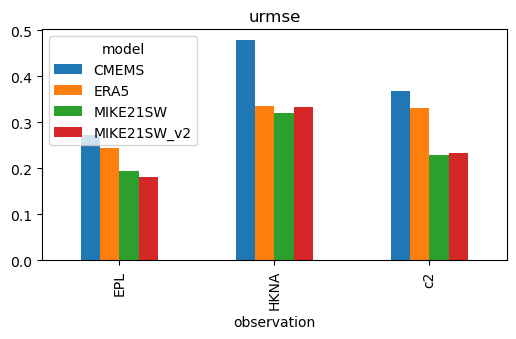

In [18]:
sk["urmse"].plot.bar(figsize=(6,3));

In [19]:
cc.mean_skill().style()

,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,
CMEMS,301,-0.388,0.564,0.372,0.463,0.910,0.106,0.419
ERA5,301,-0.336,0.452,0.303,0.366,0.931,0.087,0.506
MIKE21SW,301,0.058,0.337,0.248,0.276,0.945,0.071,0.663
MIKE21SW_v2,301,-0.064,0.341,0.249,0.276,0.945,0.071,0.741


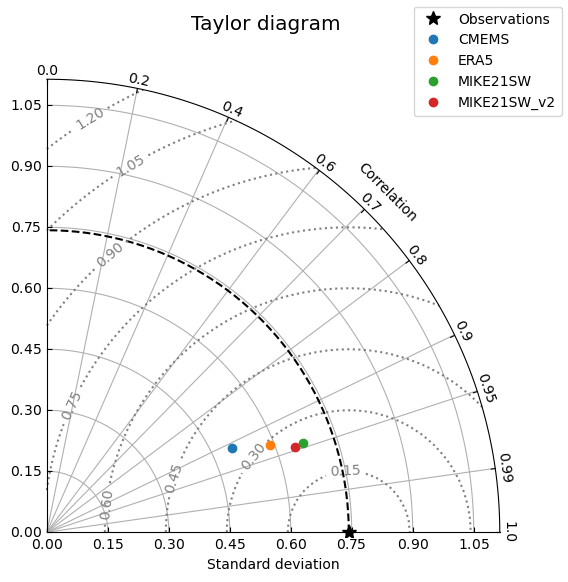

In [20]:
cc.plot.taylor(figsize=6)